In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from torch.utils.data import DataLoader
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np

### Data Path

In [99]:
train_path = '/Users/douglaszou/Downloads/fer2013/train'
test_path = '/Users/douglaszou/Downloads/fer2013/test'

### Data Transformation

In [101]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # upscale the 224 x 224 from 48 x 48
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Data loading

In [103]:
# Load datasets
trainset = datasets.ImageFolder(root=train_path, transform=transform)
testset = datasets.ImageFolder(root=test_path, transform=transform)

# Data loaders
batch_size = 8
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Display sample image batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


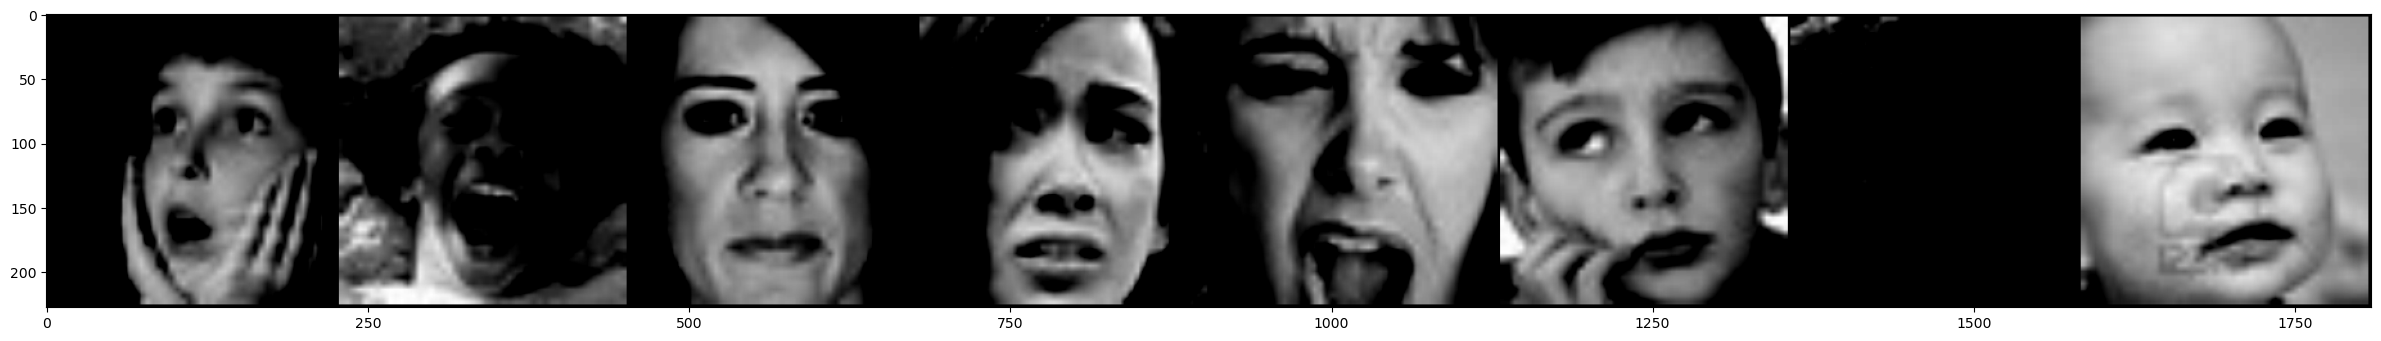

Fear | Happy | Sad | Disgust | Angry | Sad | Happy | Sad | 

In [105]:
# Display sample images
sample = next(iter(train_loader))
image, label = sample

grid = torchvision.utils.make_grid(image, nrow=8)
grid_np = grid.numpy()
grid_np = np.transpose(grid_np, (1, 2, 0))
plt.figure(figsize=(30, 30))
plt.imshow(grid_np)
plt.show()

results_label = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Show the result labels
for lb in label:
    print(results_label[int(lb)], end=" | ")

### Residual Block Definition

In [107]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

### Masking Mechanism Definition

In [109]:
class MaskingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MaskingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        mask = self.sigmoid(self.conv(x))
        out = x * mask
        return out

### Define RMN model

In [111]:
class RMN(nn.Module):
    def __init__(self, num_classes=7):
        super(RMN, self).__init__()
        self.layer1 = ResidualBlock(3, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.masking = MaskingBlock(512, 512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        masking_out = self.masking(out)  # Capture the output of the masking layer
        out = self.avg_pool(masking_out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out, masking_out  # Return the activations from the masking layer


In [112]:
# Model Initialization
model = RMN(num_classes=len(results_label))

### Move the model to GPU

In [114]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

RMN(
  (layer1): ResidualBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(

### Loss function and optimizer

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00055)

# Learning rate scheduler
# every 2 epochs, decrease the LR by 10%
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

### Model training

In [118]:
# Training loop
num_epochs = 10
tracked_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images)  # Only use the final output for loss calculation
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tracked_losses.append(running_loss)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%')

Epoch [1/10], Loss: 1.7610479101360126, Accuracy: 27.17614685290327%
Epoch [2/10], Loss: 1.5424838915911516, Accuracy: 39.935211954439374%
Epoch [3/10], Loss: 1.3258437632135973, Accuracy: 49.43745863666446%
Epoch [4/10], Loss: 1.2056807704658088, Accuracy: 53.906440489045245%
Epoch [5/10], Loss: 1.1167034478232734, Accuracy: 57.908669755129054%
Epoch [6/10], Loss: 1.039055548278227, Accuracy: 60.87638022919642%
Epoch [7/10], Loss: 0.9605693155782872, Accuracy: 64.24814518095371%
Epoch [8/10], Loss: 0.8666110678108065, Accuracy: 67.92295099097844%
Epoch [9/10], Loss: 0.7615478993604968, Accuracy: 71.9147305722944%
Epoch [10/10], Loss: 0.6392408062356965, Accuracy: 76.69720296771047%


### Evaluations

In [120]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Display overall accuracy
print(f'Test Accuracy: {100 * correct/total}%')

Test Accuracy: 61.36806910002786%


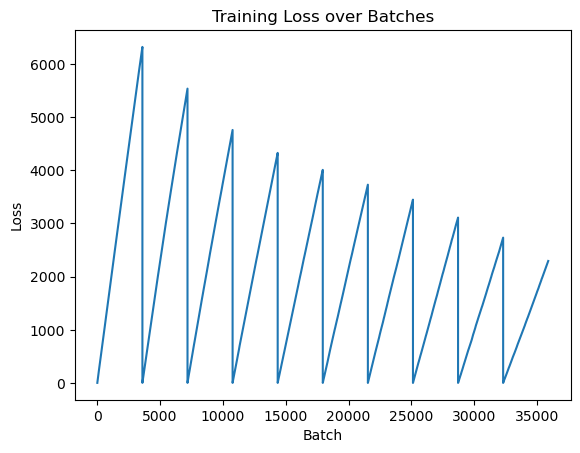

In [121]:
# Visualize batch losses
plt.plot(tracked_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.show()

In [122]:
# Function to generate and display saliency map on a given axis
def show_saliency_map(model, image, label, ax):
    model.eval()
    image.requires_grad_()
    
    # Forward pass
    output, _ = model(image)
    
    # Get the index of the predicted class
    pred_class = output.argmax(dim=1)
    
    # Compute the loss for the predicted class
    loss = criterion(output, pred_class)
    
    # Backward pass to compute the gradients
    model.zero_grad()
    loss.backward()
    
    # Get the saliency map
    saliency = image.grad.data.abs().squeeze().cpu().numpy()
    saliency = saliency.max(axis=0)  # Take the maximum value across the color channels
    
    # Normalize the saliency map
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    # Display the image and saliency map
    image_np = image.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    ax[0].imshow(image_np)
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    
    ax[1].imshow(saliency, cmap='hot')
    ax[1].axis('off')
    ax[1].set_title('Saliency Map')

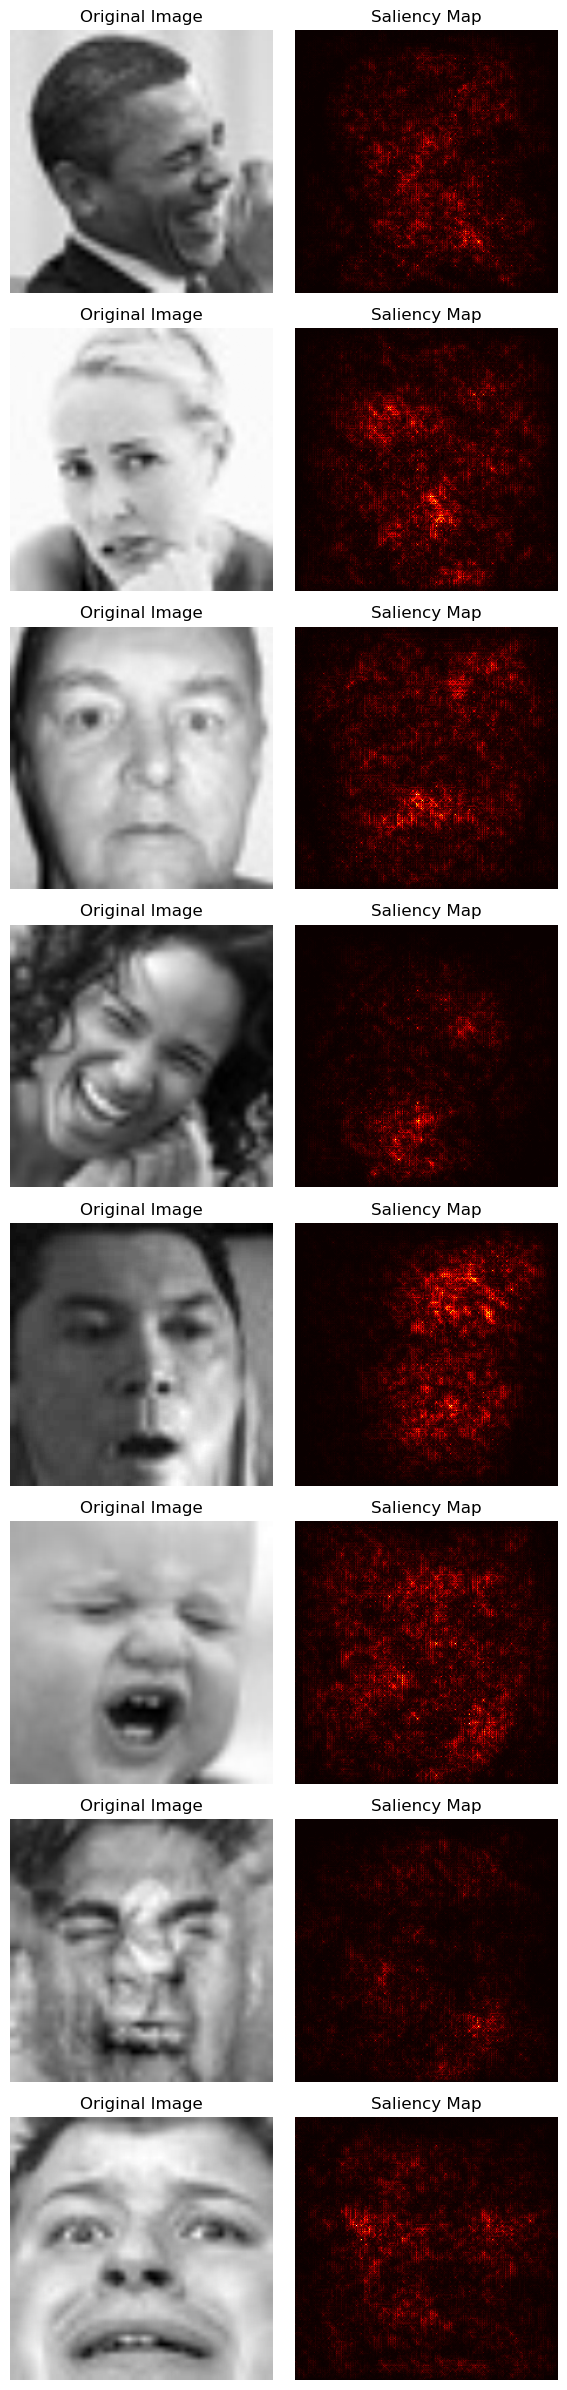

In [123]:
# Get a sample image and label from the train loader
sample = next(iter(train_loader))
images, labels = sample
images, labels = images.to(device), labels.to(device)

# Determine the number of rows and columns for the subplot
num_images = len(images)
num_cols = 2
num_rows = num_images

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6, num_rows * 3))

# Loop through images and labels
for i in range(num_images):
    show_saliency_map(model, images[i].unsqueeze(0), labels[i], axs[i, :])

plt.tight_layout()
plt.show()

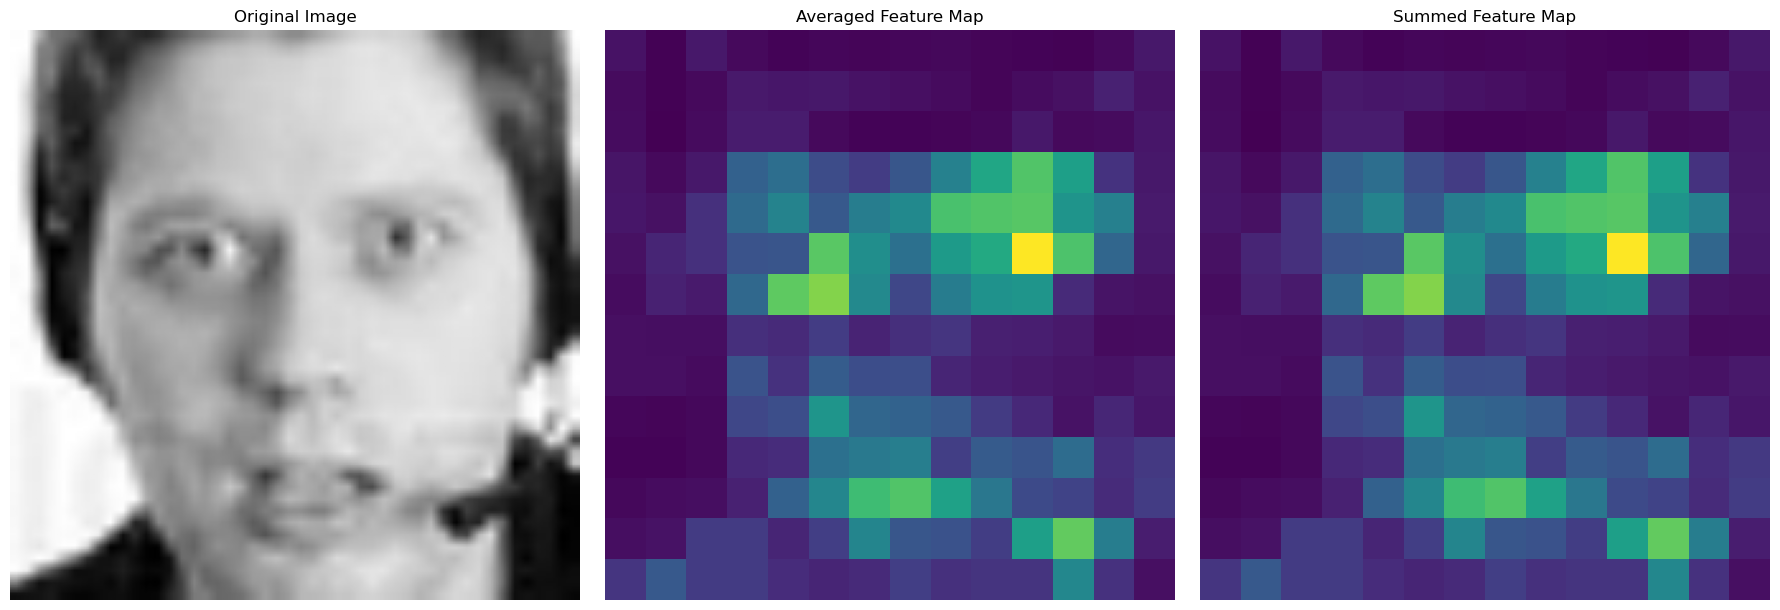

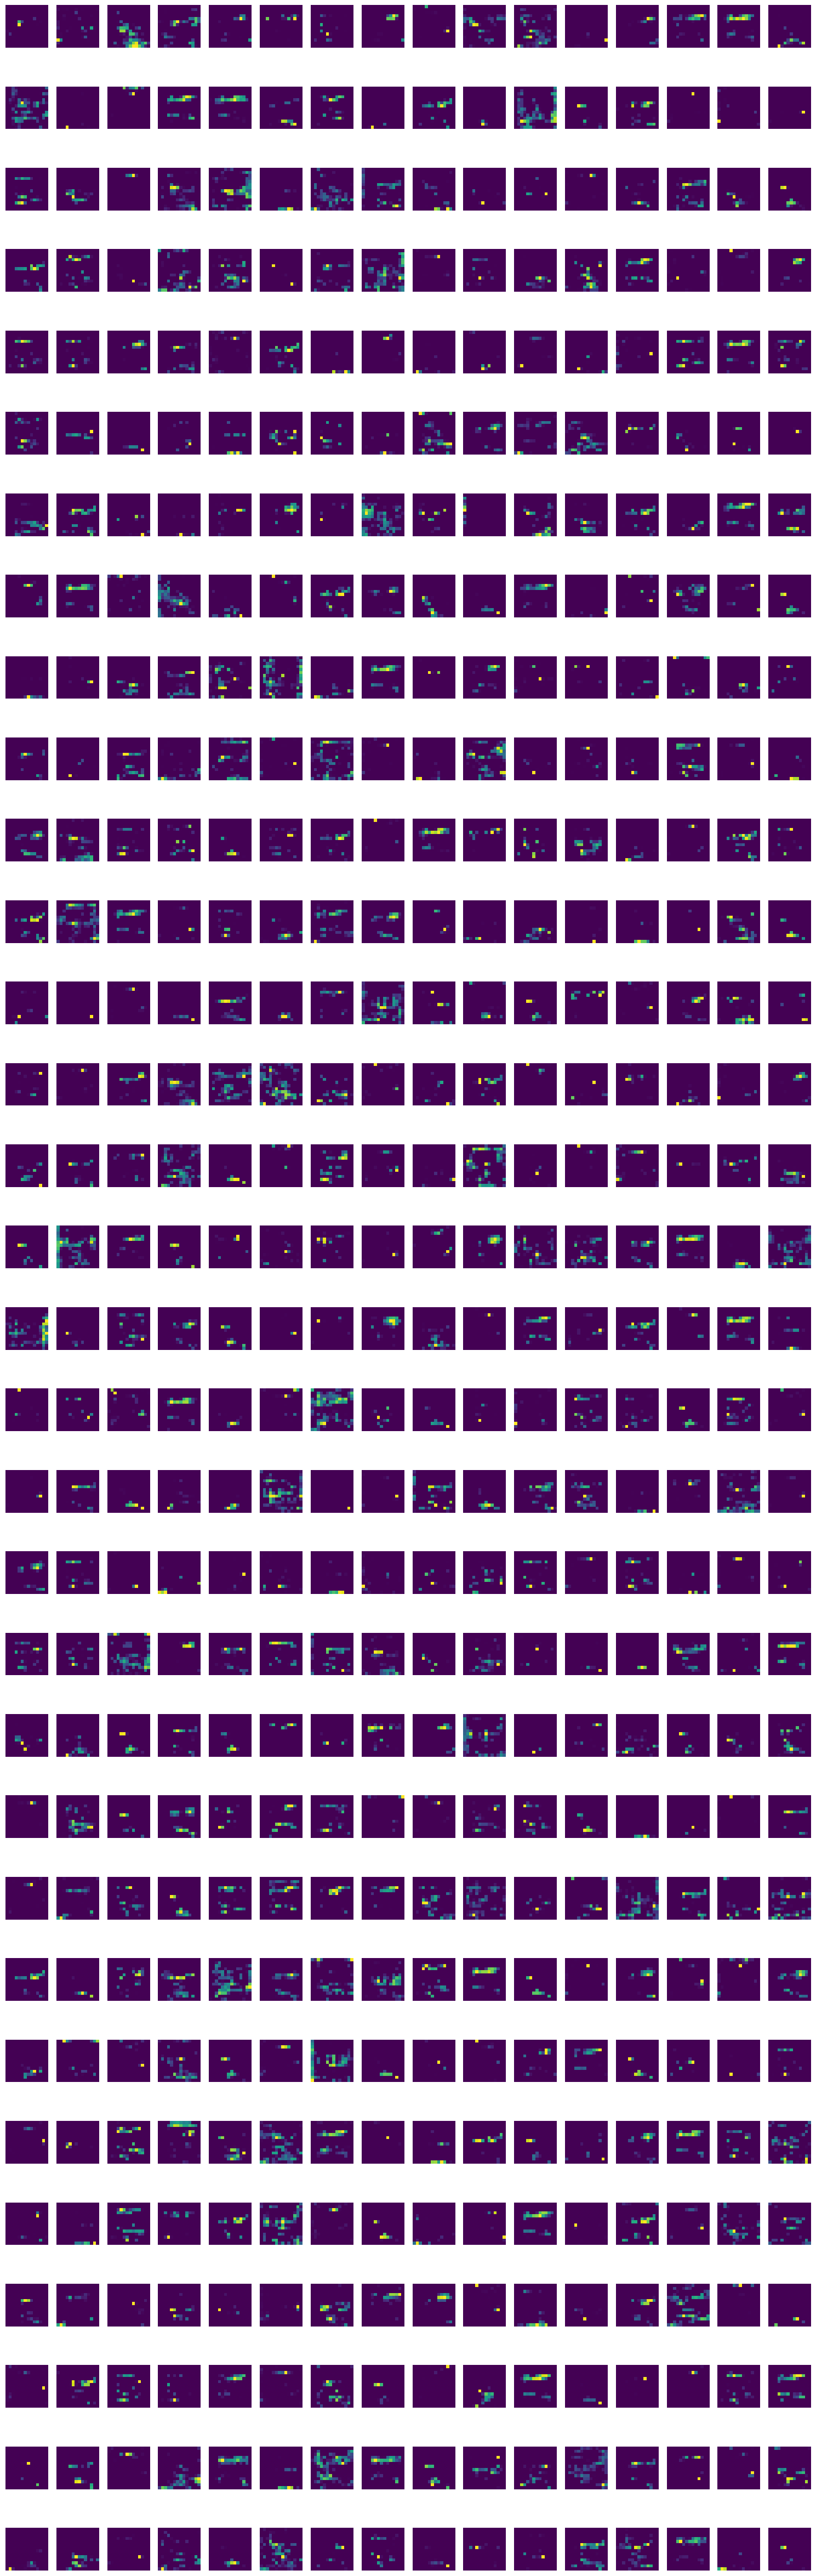

In [155]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_combined_feature_map(image, feature_maps):
    # Convert the image tensor to a numpy array and transpose to HxWxC
    image_np = image.cpu().numpy().transpose(1, 2, 0)

    # Normalize the image for better visualization (if necessary)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Method 1: Averaging the feature maps
    avg_feature_map = np.mean(feature_maps, axis=0)

    # Method 2: Summing the feature maps
    sum_feature_map = np.sum(feature_maps, axis=0)

    # Plot the original image, averaged feature map, and summed feature map
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(image_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(avg_feature_map, cmap='viridis')
    ax[1].set_title('Averaged Feature Map')
    ax[1].axis('off')

    ax[2].imshow(sum_feature_map, cmap='viridis')
    ax[2].set_title('Summed Feature Map')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Method 3: Creating a montage of feature maps
    num_filters = feature_maps.shape[0]
    num_cols = 16
    num_rows = num_filters // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 1.5))

    for i in range(num_rows):
        for j in range(num_cols):
            ax = axs[i, j]
            ax.imshow(feature_maps[i * num_cols + j], cmap='viridis')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Get a sample image from the train loader
sample = next(iter(train_loader))
images, labels = sample
images, labels = images.to(device), labels.to(device)

# Visualize the masking layer for the first image in the batch
model.eval()
with torch.no_grad():
    _, masking_out = model(images[1].unsqueeze(0).to(device))

masking_out = masking_out.squeeze().cpu().numpy()

# Visualize the combined feature map
visualize_combined_feature_map(images[1], masking_out)
